In [42]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#torch specific
import torch
import torchvision as torchv
import torch.optim as optim

#other libraries
import time
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from tqdm import tqdm

#Using newest versions of all libraries

In [43]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from imcal import *
from imcal import CalorimeterDataset
from imcal import Hdf5Dataset
from imcal import RandomRoll
from imcal import plot_conf_matrix

In [52]:
#variables controlled by the user. Change these to fit your specific needs.
TRAIN_N_EVENTS = 10000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.
TEST_N_EVENTS = 3000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.
RES = 50 #resolution

#Data specification
LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10"] #for plotting #"PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", 
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH", "n2_M10", "n4_M10", "n6_M10"]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
#"PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL"

FOLDERS = ["sph", "BH", "BH", "BH"]

"""
LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n4_M10"] #for plotting 
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9TeV", "BH_n4_M10"]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
#"PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL"

FOLDERS = ["sph", "BH"]
"""

TRAIN_FILENAMES = [f"{label}_res{RES}_10000_events.h5" for label in LABELS]
TEST_FILENAMES = [f"{label}_res{RES}_3000_events.h5" for label in TEST_LABELS]
TRAIN_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TRAIN_FILENAMES[i]}" for i in range(CLASSES)] #The path to the folder containing the training histogram files
TEST_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TEST_FILENAMES[i]}" for i in range(CLASSES)] #The path to the folder containing the testing histogram files

SAVE_PATH = "/home/agrefsru/imcalML/results"

MODEL_NAME = f'resnet_{str(int(time.time()))}' #A unique name for the model
print(MODEL_NAME)

filters=None

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")


resnet_1670936094
Running on the GPU


In [45]:

testpaths = [Path(path) for path in TEST_DATAPATHS]

test_data = Hdf5Dataset(testpaths, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=filters, transform=None, event_limit=TEST_N_EVENTS)

#test_data = load_datasets(testpaths, DEVICE, TEST_N_EVENTS, filters, transforms)

df_labels = ["n", "resolution", "training samples", "epochs", "learning rate", "transforms", "filters", "mean accuracy", "std accuracy"]

results = pd.DataFrame(columns=df_labels)

transforms = torch.nn.Sequential(
        torchv.transforms.RandomVerticalFlip(),
        #torchv.transforms.RandomHorizontalFlip(),
        RandomRoll(1)
    )

from resnet import ResNet18


In [46]:

def experiment(df, testdata, n_train, n, epochs, lr, transforms):
    scores = np.zeros(n)

    """traindata = Hdf5Dataset(TRAIN_DATAPATH, LABELS, DEVICE, 
                        shuffle=True, transform=transforms, event_limit=n_train)
    """
    trainpaths = [Path(path) for path in TRAIN_DATAPATHS]
    traindata = load_datasets(trainpaths, DEVICE, n_train, filters, transforms)
    #traindata = Hdf5Dataset(trainpaths, LABELS, DEVICE, 
                       # shuffle=True, transform=transforms, event_limit=n_train)
    for i in range(n):
        print(f"Iteration {i}")
        resnet = ResNet18(img_channels=3, num_classes=CLASSES)
        resnet.to(DEVICE)
        optimizer = optim.Adam(resnet.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.001,step_size_up=5,mode="exp_range",gamma=0.85, cycle_momentum=False)
        training_results = train(resnet, traindata, testdata, 2**8, epochs, RES, DEVICE, optimizer, scheduler)
        truth, preds = predict(resnet, testdata, CLASSES, 100, RES, DEVICE)
        accuracy = accuracy_score(truth, preds, normalize=True)
        scores[i]= accuracy
    data = {"n":n, 
            "resolution": RES,
            "training samples": len(traindata), 
            "epochs" : epochs, 
            "learning rate" : lr, 
            "transforms"  : [transforms], 
            "filters" : filters, 
            "mean accuracy" : scores.mean(), 
            "std accuracy" : scores.std()}
    new_data = pd.DataFrame(data)
    new_df = pd.concat([df, new_data], ignore_index=True)
    return new_df, training_results, resnet


In [47]:
#Run n experiments to find statistics on accuracy
transforms = torch.nn.Sequential(
        torchv.transforms.RandomVerticalFlip(),
        RandomRoll(roll_axis=0)
    )
results, training_results, resnet = experiment(df=results, n_train=10000, testdata=test_data, 
                                                n=5, epochs=20, lr=0.0001, transforms=transforms)

Loads data with transforms Sequential(
  (0): RandomVerticalFlip(p=0.5)
  (1): RandomRoll()
) and filters None
Loaded data with 10000 entries of shape (10000, 50, 50, 3).
Check max value: 13608.056640625.
Loaded data with 10000 entries of shape (10000, 50, 50, 3).
Check max value: 18448.443359375.
Loaded data with 10000 entries of shape (10000, 50, 50, 3).
Check max value: 38417.67578125.
Loaded data with 10000 entries of shape (10000, 50, 50, 3).
Check max value: 29551.619140625.
Data has shape torch.Size([50, 50, 3])
There are 4 classes.
Iteration 0


100%|██████████| 120/120 [00:08<00:00, 13.46it/s]


Iteration 1


100%|██████████| 120/120 [00:08<00:00, 13.63it/s]


Iteration 2


100%|██████████| 120/120 [00:08<00:00, 13.81it/s]


Iteration 3


100%|██████████| 120/120 [00:08<00:00, 13.77it/s]


Iteration 4


100%|██████████| 120/120 [00:08<00:00, 13.78it/s]


In [48]:
results

,n,resolution,training samples,epochs,learning rate,transforms,filters,mean accuracy,std accuracy
0,5,50,40000,20,0.0001,"[RandomVerticalFlip(p=0.5), RandomRoll()]",None,0.49935,0.006412


In [49]:
results.to_csv(f"{SAVE_PATH}/{MODEL_NAME}_results.csv")
results.to_pickle(f"{SAVE_PATH}/{MODEL_NAME}_results.pkl")

<AxesSubplot:xlabel='Iteration'>

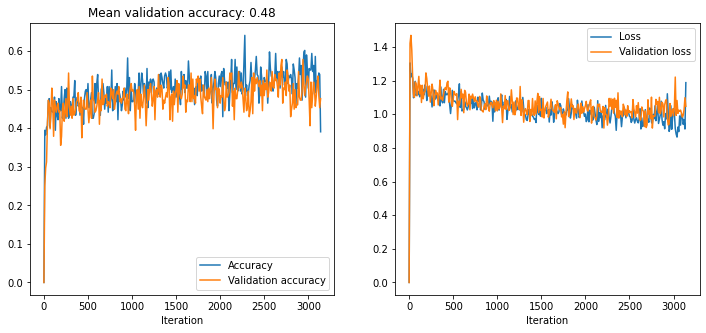

In [50]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
training_results.plot("Iteration", ["Accuracy", "Validation accuracy"], ax=axs[0], 
                    title="Mean validation accuracy: " + str(round(training_results["Validation accuracy"].mean(), 2)))
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[1])
#axs[0].set_ylim(0.6, 1)

100%|██████████| 120/120 [00:08<00:00, 14.10it/s]


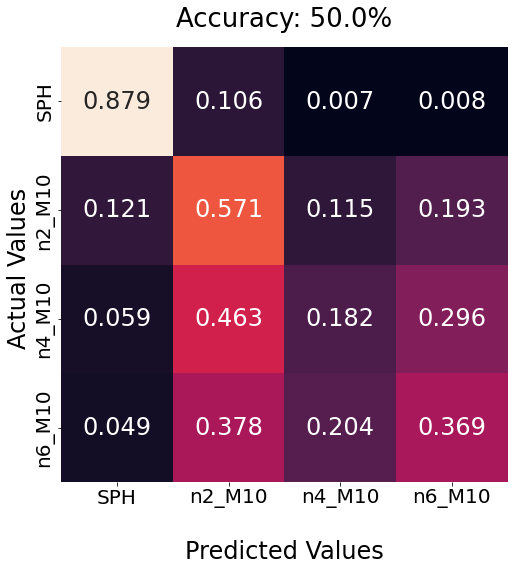

In [53]:
truth, preds = predict(resnet, test_data, CLASSES, 100, RES, DEVICE)
confusion = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
accuracy = accuracy_score(truth, preds, normalize=True)
plot_conf_matrix(confusion, accuracy, PLOT_LABELS)